### Setup

In [1]:
import numpy as np
import glob, os
from tqdm.auto import tqdm

In [2]:
# Setting up the cache directory
import os
caches_dir = ["Y:/.cache/", "E:/.cache/"]

# Will set the cache in the first caches dir found in the storage
for cache in caches_dir:
    if os.path.exists(cache):
        os.environ['HF_HOME'] = cache
        print(f"Cache path set on {cache}")
        break
    else:
        print(f"Path does not  exist {cache}")

Cache path set on Y:/.cache/


In [508]:
path = r"Y:\ML\datasets\leaf\Dahon"
path = r"Y:\ML\datasets\bonsai\tree"
if not os.path.exists(path):
    print(f"Path does not  exist {path}")

In [509]:
import datasets
datasets.enable_progress_bars

# load a custom dataset from local/remote files or folders using the ImageFolder feature
dataset = datasets.load_dataset("imagefolder", data_dir=path, split="train").cast_column("image", datasets.Image(decode=False))
dataset

Resolving data files:   0%|          | 0/297 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 297
})

## Inference

In [39]:
from transformers import pipeline
from PIL import Image
import torch
import requests
import time

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name()

In [41]:
# Setup the pipeline for model inference
detector_id = "IDEA-Research/grounding-dino-tiny"
object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

In [510]:
# Add more candidate labels here for object identification
# Leaf
# Other = human, animal, etc.
# Unknown =  sometimes shows up, sometimes not
main_label = 'leaf.'
negative_label = 'unknown.'
labels = [main_label, negative_label] 

In [511]:
true_labels = ['leaf.'] * len(dataset['image'])

predicted_labels = []
misclassified_images_path = []
misclassified_labels = []

In [512]:
# Grounding Dino labels eg. ['cat.', 'dog.']
labels = [label if label.endswith(".") else label+"." for label in labels] # GroundingDino only
labels

['leaf.', 'unknown.']

### 1 Image Inference Test

In [496]:
threshold = float(0.4) # Adjust this for score predictions

In [497]:
# image_url = 'https://farm5.staticflickr.com/4002/4317501608_5640c9e769_z.jpg' # Use this for image link
# image = Image.open(requests.get(image_url, stream=True).raw)

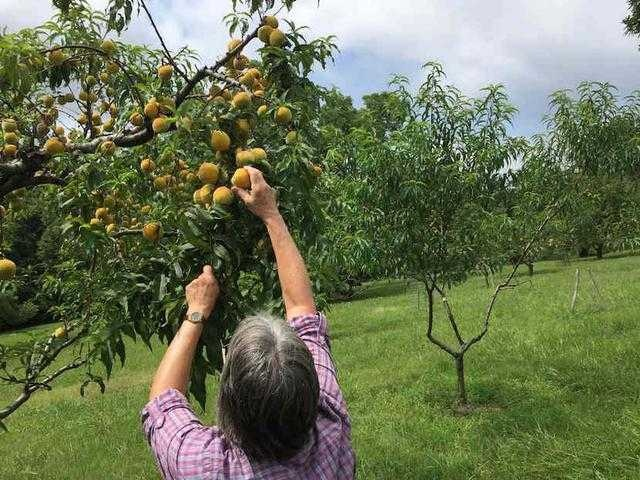

In [518]:
path = dataset[0]['image']['path']
image = Image.open(path).convert('RGB')
image

In [515]:
start = time.time()
predictions = object_detector(image, candidate_labels=labels, threshold=threshold)
end = time.time()
print(f"Took %.2f s on {device_name}" % ((end - start)))

Took 2.24 s on NVIDIA GeForce GTX 1650


In [516]:
predictions

[{'score': 0.5093681812286377,
  'label': 'unknown.',
  'box': {'xmin': 140, 'ymin': 165, 'xmax': 357, 'ymax': 478}}]

### Inference on all of dataset

In [519]:
threshold = float(0.4)

In [ ]:
start = time.time()
# Inference process on dataset
for i, item in tqdm(enumerate(dataset['image'])):
    image = Image.open(item['path'])
    result = object_detector(image, candidate_labels=labels) # set image and labels query
    
    if predictions: 
        predicted_label = max(predictions, key=lambda x: x['score'])['label']
    else:
        predicted_label = 'unknown.'
        
    predicted_labels.append(predicted_label)
    
    # Check if the prediction is correct
    if predicted_label != true_labels[i]:
        misclassified_images_path.append(item['path'])
        misclassified_labels.append((predicted_label, true_labels[i])) # Tuples 
        
print("Took %.2f s" % ((end - start)))

0it [00:00, ?it/s]

## Visualization

### 1 Image Inference Test

In [501]:
# display the higheest top 3 predictions
from PIL import ImageDraw, Image, ImageFont

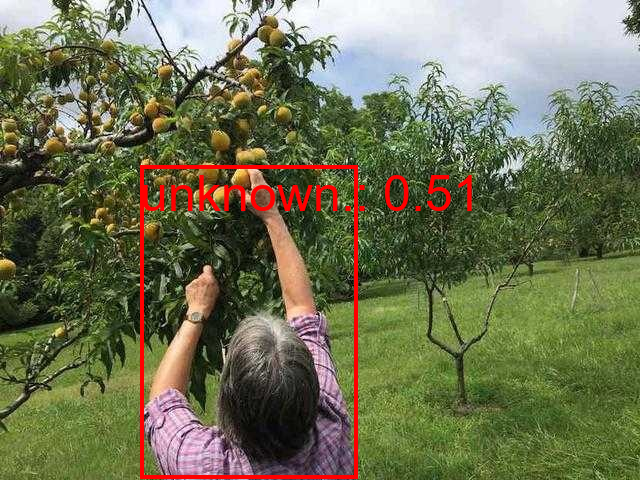

In [517]:
draw = ImageDraw.Draw(image)

for prediction in predictions[:3]: # Take the top 3 predictions
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    
    # Define the font and size
    font = ImageFont.truetype('arial.ttf', size=50)
    
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=4)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="red", font=font)

image

### Data Visualization

In [489]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

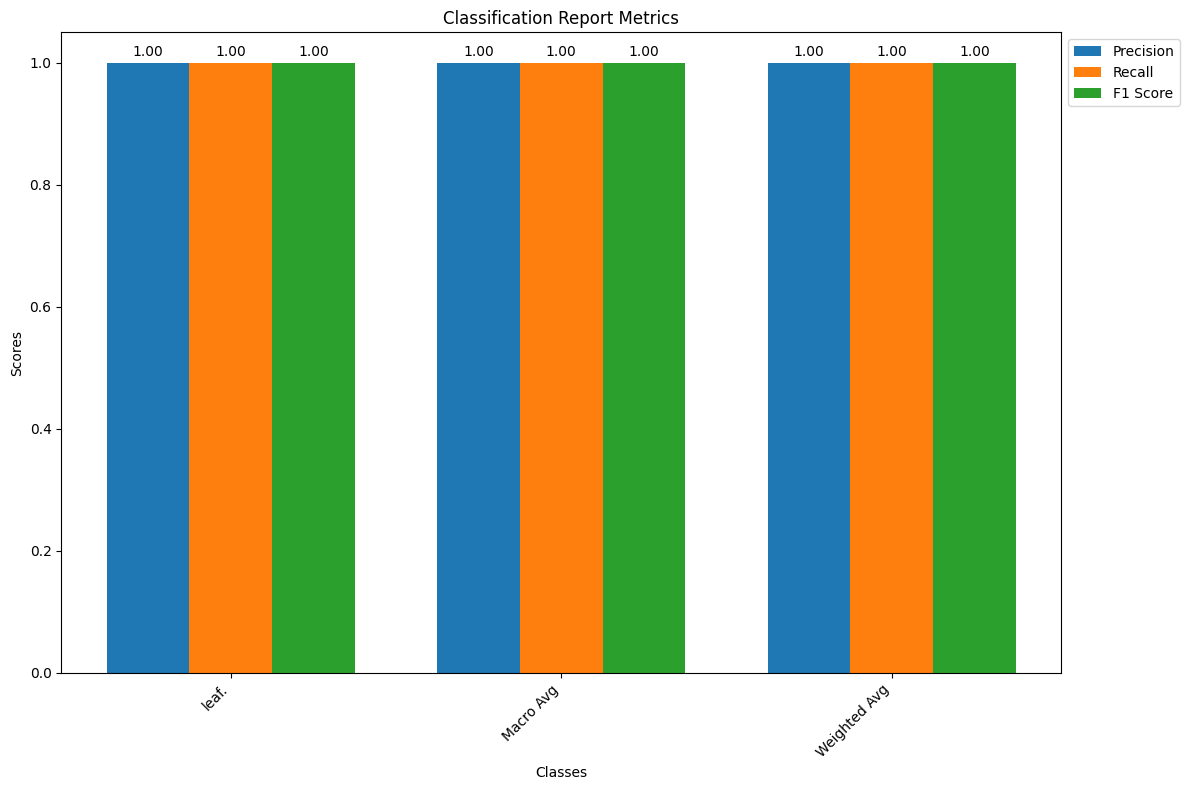

Overall Accuracy: 1.000


In [505]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract class-wise metrics
precision = report_df['precision'][:-3]
recall = report_df['recall'][:-3]
f1_score = report_df['f1-score'][:-3]

# Extract overall metrics
accuracy = report_df.loc['accuracy']['f1-score']
macro_avg = report_df.loc['macro avg'][['precision', 'recall', 'f1-score']]
weighted_avg = report_df.loc['weighted avg'][['precision', 'recall', 'f1-score']]

# Plotting
labels = precision.index.tolist() + ['Macro Avg', 'Weighted Avg']
precision = precision.tolist() + [macro_avg['precision'], weighted_avg['precision']]
recall = recall.tolist() + [macro_avg['recall'], weighted_avg['recall']]
f1_score = f1_score.tolist() + [macro_avg['f1-score'], weighted_avg['f1-score']]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Place legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Function to add labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Attach labels to bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('Classification Report Metrics.png', dpi=300)  # Increase dpi for higher quality
plt.show()

# Print overall accuracy separately
print(f"Overall Accuracy: {accuracy:.3f}")

In [506]:
report

{'leaf.': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 112.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 112.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 112.0}}

In [507]:
labels = ['tree', 'leaf', 'unknown']
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
cm

ValueError: At least one label specified must be in y_true

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Classification of Trees')
plt.tight_layout()
plt.savefig('heatmap.png', dpi=300)  # Increase dpi for higher quality
plt.show()

### Misclassified Images

In [ ]:
from collections import defaultdict

# Group the misclassified Images
misclassified_by_class = defaultdict(list)

for path, (pred_label, true_label) in zip(misclassified_images_path, misclassified_labels):
    misclassified_by_class[true_label].append((path, pred_label))

In [ ]:
# Display misclassified images
def display_misclassified_images(misclassified_by_class, images_per_class=3):
    classes = list(misclassified_by_class.keys())
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 3, num_classes * 3))
    
    for i, cls in tqdm(enumerate(classes)):
        misclassified_images = misclassified_by_class[cls]
        for j in tqdm(range(min(images_per_class, len(misclassified_images)))):
            img_path, pred_label = misclassified_images[j]
            image = Image.open(img_path)
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(image)
            ax.set_title(f"True: {cls}\nPred: {pred_label}")
            ax.axis('off')
            
    plt.tight_layout()
    plt.savefig('Misclassifications.png', dpi=300)  # Increase dpi for higher quality
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_by_class, images_per_class=10)

In [ ]:
img_path = misclassified_images_path[0]
rlabels = misclassified_labels[0]
image = Image.open(img_path)
pred_label, true_label = rlabels
plt.imshow(image)
plt.title(f"Predicted: {pred_label} \n True: {true_label}")
plt.axis('off')